# Introduction

This notebook plots the traces and the results of the experiments using the synthetic traces.

In [1]:
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

sns.set_style("whitegrid")


DIR_FIGS = Path("figs")
DIR_TRACES = Path("traces/synth")
TRACES = [
    "static",
    "decreasing",
    "increasing",
    "periodic",
    "unpredictable",
    "once",
    "everything",
]
TRACE_ORDER = [
    "static",
    "periodic",
    "increasing",
    "decreasing",
    "unpredictable",
    "once",
    "everything",
    "static/periodic",
    "static/increasing",
    "static/decreasing",
    "static/unpredictable",
    "static/once",
    "static/everything",
    "periodic/unpredictable",
    "periodic/once",
    "periodic/everything",
    "increasing/periodic",
    "increasing/decreasing",
    "increasing/unpredictable",
    "increasing/once",
    "increasing/everything",
    "decreasing/periodic",
    "decreasing/unpredictable",
    "decreasing/once",
    "decreasing/everything",
    "unpredictable/once",
    "unpredictable/everything",
    "once/everything",
]

# Plot traces

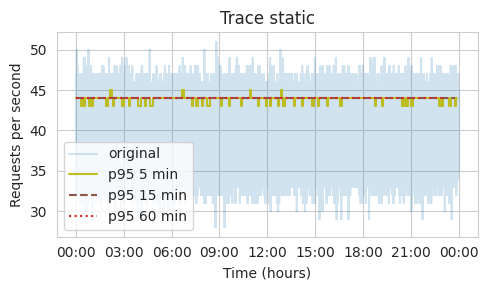

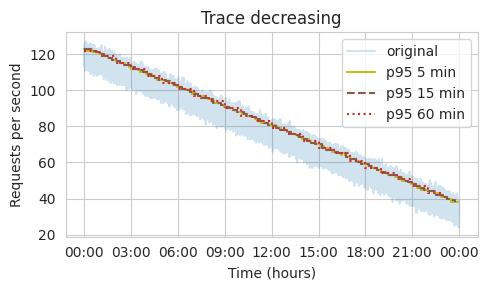

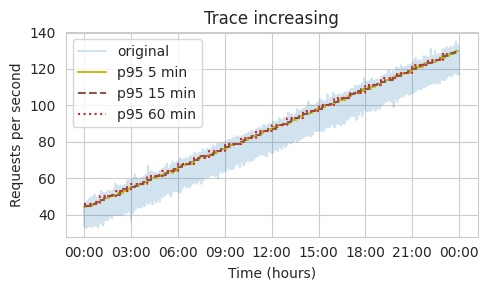

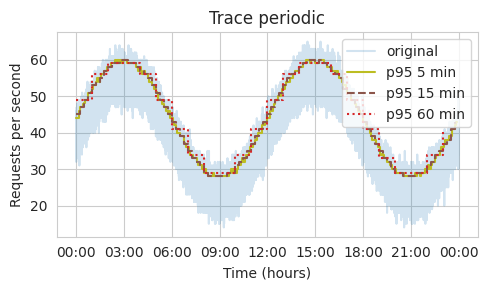

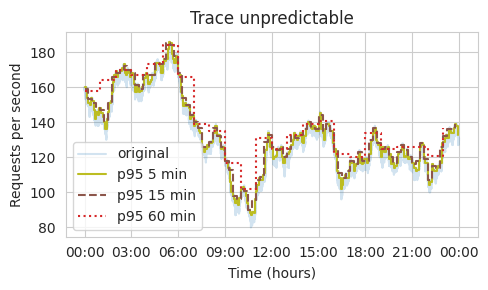

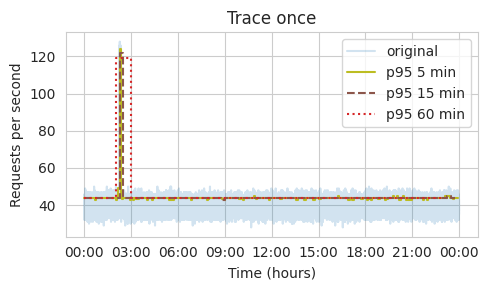

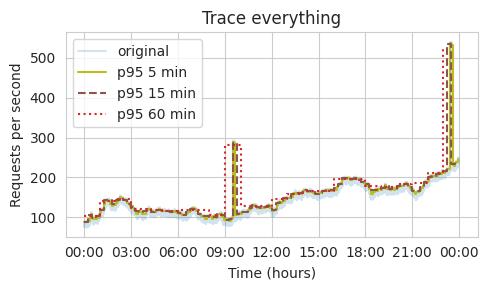

In [2]:
df_sec = {}
for trace in TRACES:
    file_name = f"{DIR_TRACES}/wl_{trace}_1s.csv"
    df_sec[trace] = pd.read_csv(file_name, header=None, names=["reqs"])
    df_sec[trace].index = pd.to_datetime(df_sec[trace].index, unit="s")

window_sizes_min = [5, 15, 60]
line_styles = {
    5: "-",
    15: "--",
    60: ":",
}
colors = {
    5: "tab:olive",
    15: "tab:brown",
    60: "tab:red",
}

df_agg = {trace: {} for trace in TRACES}
for trace in TRACES:
    for window_size_min in window_sizes_min:
        window_size_str = f"{window_size_min}T"

        df_agg[trace][(window_size_min, "p95")] = (
            df_sec[trace].resample(window_size_str).quantile(q=0.95)
            * 60
            * window_size_min
        )

# Plot the rps of each trace in a figure with the original trace per second and the trace
# aggregated with different window sizes

for trace in TRACES:
    # Plot the original trace
    fig, ax = plt.subplots(figsize=(5, 3))
    ax.plot(df_sec[trace], label="original", alpha=0.2)

    # Plot the aggregated traces, each with a different line style, using a step function
    for window_size_min in window_sizes_min:
        window_size_str = f"{window_size_min}T"
        ax.plot(
            df_agg[trace][(window_size_min, "p95")] / (window_size_min * 60),
            label=f"p95 {window_size_min} min",
            linestyle=line_styles[window_size_min],
            color=colors[window_size_min],
            drawstyle="steps-post",
        )

    # Put the x axis in hours
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

    ax.set_xlabel("Time (hours)")
    ax.set_ylabel("Requests per second")
    ax.set_title(f"Trace {trace}")
    ax.legend()

    fig.tight_layout()

    fig.savefig(f"{DIR_FIGS}/synth_traces_p95_{trace}.pdf")

# Results

In [3]:
file_name = "summary.csv"
df = pd.read_csv(file_name)
df

,num_apps,trace,window_size_sec,allocator,cost_usd,vms
0,1,static,300,conlloovia,0.070833,4.0
1,1,static,300,conlloovia,0.070833,4.0
2,1,static,300,conlloovia,0.070833,4.0
3,1,static,300,conlloovia,0.070833,4.0
4,1,static,300,conlloovia,0.070833,4.0
...,...,...,...,...,...,...
34219,2,once/everything,3600,FFP,17.000000,125.0
34220,2,once/everything,3600,FFP,16.660000,124.0
34221,2,once/everything,3600,FFP,17.340000,126.0
34222,2,once/everything,3600,FFP,17.680000,127.0


In [4]:
df_gr = df.groupby(["num_apps", "trace", "allocator", "window_size_sec"]).sum()
df_gr

cost_usd     vms
num_apps trace              allocator  window_size_sec                    
1        decreasing         FFC        300               40.679583  1526.0
                                       900               40.693750   509.0
                                       3600              41.055000   129.0
                            FFP        300               40.155417  5669.0
                                       900               40.183750  1891.0
...                                                            ...     ...
2        unpredictable/once FFP        900              161.330000  6676.0
                                       3600             168.980000  1714.0
                            conlloovia 300              147.687500  6138.0
                                       900              149.833750  2078.0
                                       3600             156.825000   538.0

[252 rows x 2 columns]

In [5]:
# Normalize the cost_usd column by dividing by the base value, which is the cost of
# conlloovia with a window size of 300 seconds
df_gr_norm = df_gr.reset_index().copy()

# Find the base value for each trace
base_values = df_gr_norm.loc[
    (df_gr_norm["window_size_sec"] == 300) & (df_gr_norm["allocator"] == "conlloovia"),
    ["trace", "cost_usd"],
]
base_values = base_values.rename(columns={"cost_usd": "base_value"})

# Merge the base values with the original dataframe
df_gr_norm = df_gr_norm.merge(base_values, on="trace")

# Normalize the cost_usd column
df_gr_norm["cost_usd_normalized"] = df_gr_norm["cost_usd"] / df_gr_norm["base_value"]
df_gr_norm["cost_diff_pct"] = 100 * (df_gr_norm["cost_usd_normalized"] - 1)
df_gr_norm

,num_apps,trace,allocator,window_size_sec,cost_usd,vms,base_value,cost_usd_normalized,cost_diff_pct
0,1,decreasing,FFC,300,40.679583,1526.0,35.990417,1.130289,13.028931
1,1,decreasing,FFC,900,40.693750,509.0,35.990417,1.130683,13.068294
2,1,decreasing,FFC,3600,41.055000,129.0,35.990417,1.140720,14.072033
3,1,decreasing,FFP,300,40.155417,5669.0,35.990417,1.115725,11.572525
4,1,decreasing,FFP,900,40.183750,1891.0,35.990417,1.116512,11.651250
...,...,...,...,...,...,...,...,...,...
247,2,unpredictable/once,FFP,900,161.330000,6676.0,147.687500,1.092374,9.237410
248,2,unpredictable/once,FFP,3600,168.980000,1714.0,147.687500,1.144173,14.417266
249,2,unpredictable/once,conlloovia,300,147.687500,6138.0,147.687500,1.000000,0.000000
250,2,unpredictable/once,conlloovia,900,149.833750,2078.0,147.687500,1.014532,1.453237


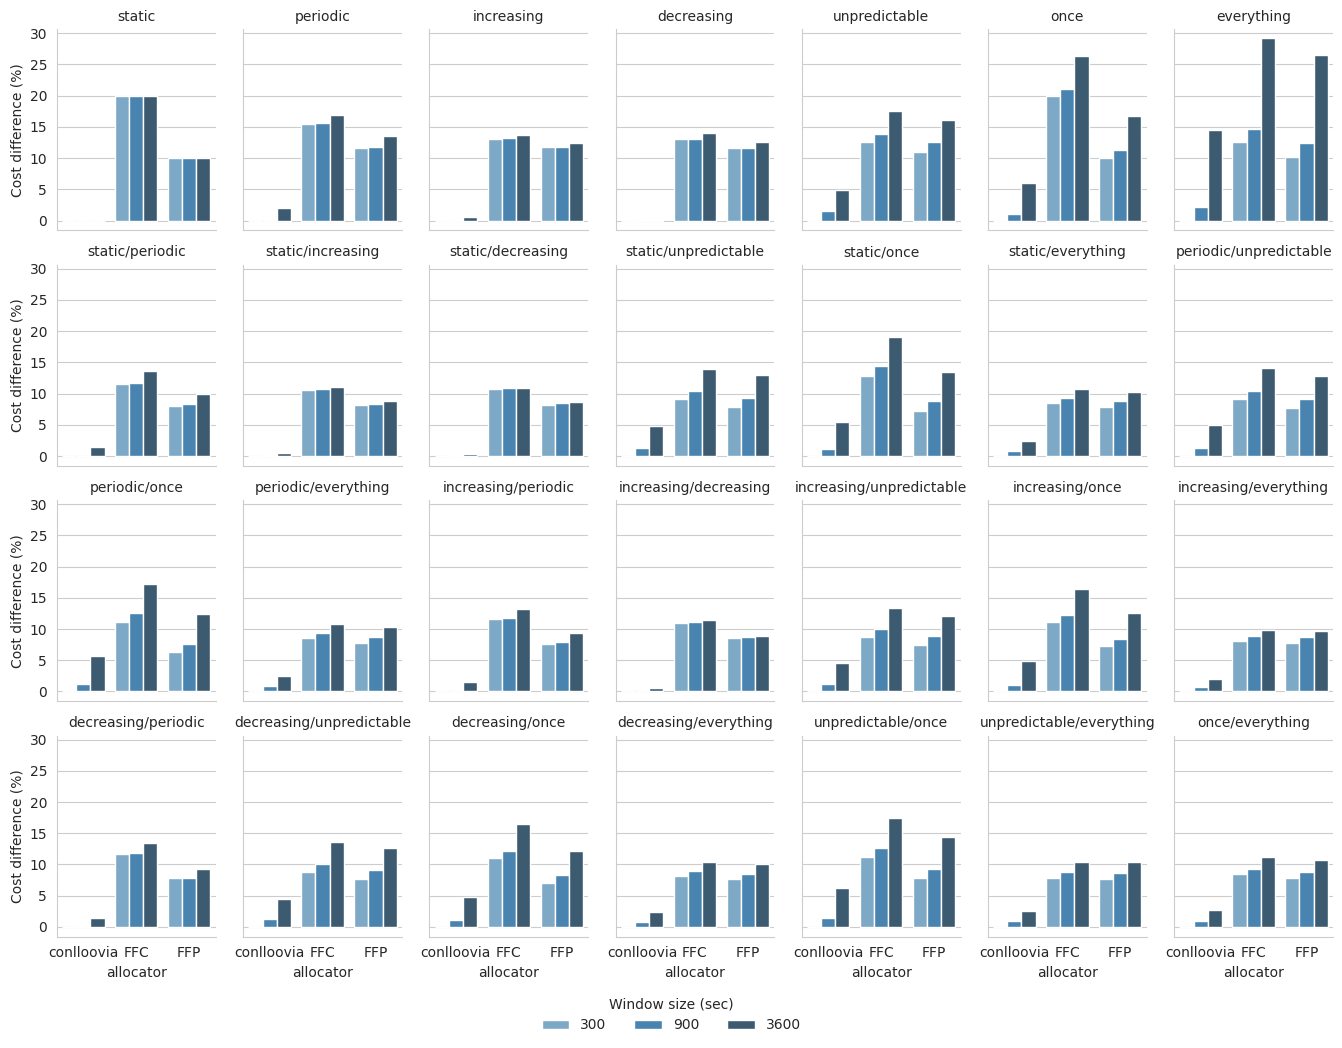

In [6]:
g = sns.catplot(
    data=df_gr_norm,
    x="allocator",
    y="cost_diff_pct",
    col="trace",
    col_wrap=7,
    hue="window_size_sec",
    kind="bar",
    order=["conlloovia", "FFC", "FFP"],
    height=2.5,
    aspect=0.7,
    palette="Blues_d",
    col_order=TRACE_ORDER,
)
g.set_titles(template="{col_name}")
g.set_ylabels("Cost difference (%)")
sns.move_legend(
    g, "lower center", bbox_to_anchor=(0.5, -0.05), title="Window size (sec)", ncol=3
)

plt.tight_layout()

g.savefig(DIR_FIGS / "cost_diff_pct.png", dpi=600)